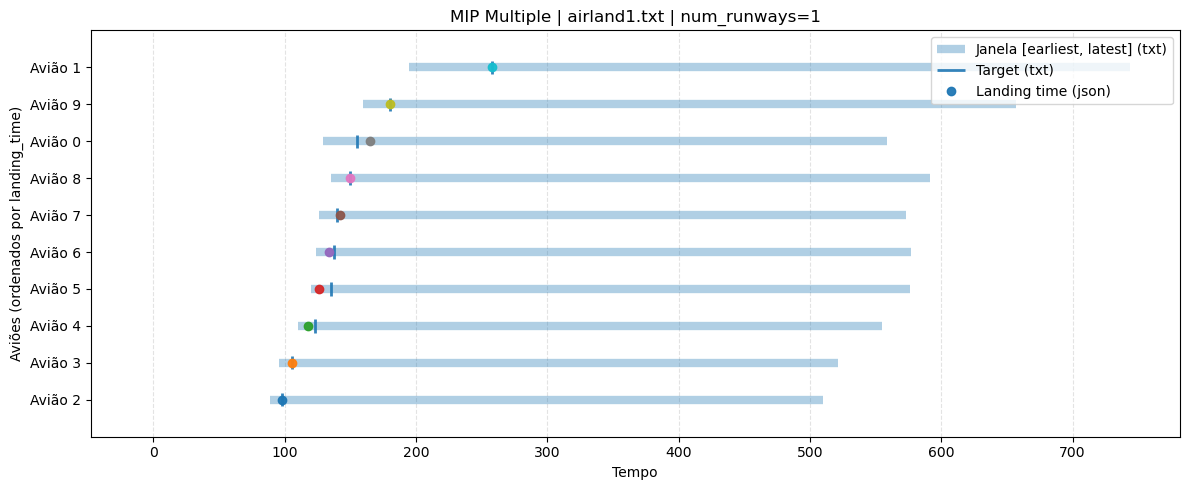

In [22]:
import json
import os
from dataclasses import dataclass
from typing import Dict, List, Optional, Any

import matplotlib.pyplot as plt


# -----------------------------
# Parsing do .txt (airland)
# -----------------------------

@dataclass
class PlaneWindow:
    idx: int
    appearance: float
    earliest: float
    target: float
    latest: float
    g: float
    h: float


@dataclass
class AirlandInstance:
    n: int
    header2: int
    planes: List[PlaneWindow]
    sep: List[List[float]]


def read_airland_txt(txt_path: str) -> AirlandInstance:
    with open(txt_path, "r", encoding="utf-8") as f:
        tokens = f.read().split()

    pos = 0
    n = int(tokens[pos]); pos += 1
    header2 = int(tokens[pos]); pos += 1

    planes: List[PlaneWindow] = []
    sep = [[0.0 for _ in range(n)] for _ in range(n)]

    for i in range(n):
        appearance = float(tokens[pos]); pos += 1
        earliest = float(tokens[pos]); pos += 1
        target = float(tokens[pos]); pos += 1
        latest = float(tokens[pos]); pos += 1
        g = float(tokens[pos]); pos += 1
        h = float(tokens[pos]); pos += 1

        planes.append(PlaneWindow(i, appearance, earliest, target, latest, g, h))

        for j in range(n):
            sep[i][j] = float(tokens[pos]); pos += 1

    return AirlandInstance(n=n, header2=header2, planes=planes, sep=sep)


# -----------------------------
# Parsing do JSON multi-solver
# -----------------------------

def load_multi_solver_json(json_path: str) -> Dict[str, List[dict]]:
    """
    Espera:
      { "MIP Single": [sol1, sol2, ...],
        "CP": [...],
        ... }
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if not isinstance(data, dict):
        raise ValueError("JSON inválido: esperado dict com chaves=solver e valores=listas de soluções.")

    # Validar que cada valor é lista
    out: Dict[str, List[dict]] = {}
    for solver, sols in data.items():
        if isinstance(sols, list):
            out[str(solver)] = sols
        else:
            raise ValueError(f"JSON inválido: solver '{solver}' não tem uma lista de soluções.")
    return out


def find_solution(solutions_by_solver: Dict[str, List[dict]], solver: str, file_name: str) -> dict:
    if solver not in solutions_by_solver:
        raise ValueError(f"Solver '{solver}' não existe no JSON. Solvers disponíveis: {list(solutions_by_solver.keys())}")

    for sol in solutions_by_solver[solver]:
        if str(sol.get("file", "")).strip() == file_name:
            return sol

    available_files = [s.get("file") for s in solutions_by_solver[solver]]
    raise ValueError(
        f"Não encontrei solução para file='{file_name}' no solver '{solver}'.\n"
        f"Files disponíveis nesse solver: {available_files}"
    )

def landing_times_and_runways(solution: dict) -> Tuple[Dict[int, float], Dict[int, int]]:
    lt: Dict[int, float] = {}
    rw: Dict[int, int] = {}
    for row in solution.get("landing_times", []):
        p = int(row["plane"])
        lt[p] = float(row["landing_time"])
        if "runway" in row and row["runway"] is not None:
            rw[p] = int(row["runway"])
    return lt, rw

def build_runway_mapping(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    num_runways: int,
    json_runways: Dict[int, int],
) -> Tuple[Dict[int, int], List[Tuple[int, int]]]:
    """
    If JSON provides runway for planes, use it.
    Otherwise, fallback to balanced assignment.

    Returns runway_of_plane, violations
    """
    if len(json_runways) == len(landing_times):
        # assume all planes have runway info
        # normalize to 0..num_runways-1 just in case
        runway_of_plane = {p: int(json_runways[p]) for p in landing_times.keys()}
        return runway_of_plane, []
    else:
        # fallback
        return assign_runways_balanced(instance, landing_times, num_runways)

# -----------------------------
# Plot Gantt / timeline
# -----------------------------

def plot_landing_gantt_multi_runway(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    runway_of_plane: Dict[int, int],
    num_runways: int,
    fancy_title: str,
    subtitle: str,
    zoom: bool = True,
):
    # Group planes by runway, then sort by landing time
    runway_planes: List[List[int]] = [[] for _ in range(num_runways)]
    for p, t in landing_times.items():
        r = runway_of_plane.get(p, 0)
        if 0 <= r < num_runways:
            runway_planes[r].append(p)
        print(f"Plane {p} assigned to runway {r} at time {t}")

    for r in range(num_runways):
        runway_planes[r].sort(key=lambda p: landing_times[p])
        print(f"Runway {r}: planes {runway_planes[r]}")

    # Build y positions with runway blocks + gaps (only if runway has planes)
    gap = 1.6
    y_positions: Dict[int, float] = {}
    runway_bounds: List[Tuple[int, float, float]] = []  # (runway_index, ymin, ymax)

    y_cursor = 0.0
    for r in range(num_runways):
        planes = runway_planes[r]
        if not planes:
            continue

        ymin = y_cursor
        for p in planes:
            y_positions[p] = y_cursor
            y_cursor += 1.0
        ymax = y_cursor - 1.0
        runway_bounds.append((r, ymin, ymax))
        y_cursor += gap

    fig_h = max(6, 0.55 * max(10, len(y_positions)))
    fig, ax = plt.subplots(figsize=(14, fig_h))

    # Segment colors (your request)
    EARLY_SEG = "#B8860B"  # dark goldenrod (dark yellow)
    LATE_SEG  = "#FF8C00"  # dark orange

    # Plot each plane
    for p, y in y_positions.items():
        pw = instance.planes[p]
        t = landing_times[p]

        # base window [earliest, latest] in gray (behind everything)
        ax.hlines(y=y, xmin=pw.earliest, xmax=pw.latest,
                  linewidth=7, alpha=0.25, zorder=1, color="gray")

        if abs(t - pw.target) > 1e-9:
            # deviation segment between landing and target (must set color!)
            seg_color = EARLY_SEG if t < pw.target else LATE_SEG
            ax.hlines(
                y=y,
                xmin=min(t, pw.target),
                xmax=max(t, pw.target),
                linewidth=7,
                alpha=0.85,
                zorder=2,
                color=seg_color,      # <-- THIS was missing in your code
            )

            # target as X above segment
            ax.scatter([pw.target], [y], marker="x", s=80, linewidths=2, zorder=4, color="black")

        # landing airplane marker always on top
        ax.scatter([t], [y],
                   marker=r"$✈$", s=240,
                   c=landing_color(t, pw.target),
                   zorder=5)

    # Runway separators + labels
    for idx, (r, ymin, ymax) in enumerate(runway_bounds):
        y_label = 0.5 * (ymin + ymax)
        ax.text(
            0.01, y_label, f"Runway {r+1}",
            transform=ax.get_yaxis_transform(),
            va="center", fontsize=11, fontweight="bold"
        )
        if idx < len(runway_bounds) - 1:
            sep_y = ymax + (gap / 2.0)
            ax.axhline(sep_y, linestyle="--", alpha=0.4, zorder=0)

    # Y ticks in order
    planes_in_order = sorted(y_positions.items(), key=lambda kv: kv[1])
    ax.set_yticks([y for _, y in planes_in_order])
    ax.set_yticklabels([f"Plane {p}" for p, _ in planes_in_order])

    ax.set_xlabel("Time")
    ax.set_ylabel("Planes (grouped by runway, sorted by landing time)")

    fig.suptitle(fancy_title, fontsize=18, fontweight="bold")
    ax.set_title(subtitle, fontsize=11, pad=10)

    ax.grid(True, axis="x", linestyle="--", alpha=0.35)

    # Legend (NOW matches the plot)
    legend_handles = [
        Line2D([0], [0], color="gray", linewidth=7, alpha=0.25, label="Window [earliest, latest]"),
        Line2D([0], [0], color=EARLY_SEG, linewidth=7, alpha=0.85, label="Early deviation (target ↔ landing)"),
        Line2D([0], [0], color=LATE_SEG, linewidth=7, alpha=0.85, label="Late deviation (target ↔ landing)"),
        Line2D([0], [0], marker="x", linestyle="None", markersize=10, color="black", label="Target (X)"),
        Line2D([0], [0], marker=r"$✈$", linestyle="None", markersize=12, color="green", label="Landing on target"),
        Line2D([0], [0], marker=r"$✈$", linestyle="None", markersize=12, color="yellow", label="Landing early"),
        Line2D([0], [0], marker=r"$✈$", linestyle="None", markersize=12, color="red", label="Landing late"),
    ]
    ax.legend(handles=legend_handles, loc="upper right", framealpha=0.9)

    # Zoom x-axis
    if zoom:
        xmin, xmax = compute_zoom_limits(instance, landing_times, pad=25.0)
        ax.set_xlim(xmin, xmax)

    plt.tight_layout()
    plt.show()


# -----------------------------
# Main
# -----------------------------

def main(
    txt_path: str,
    solutions_json_path: str,
    solver: str,
    file_name_in_json: Optional[str] = None,
    sort_by_time: bool = True,
):
    instance = read_airland_txt(txt_path)
    solutions_by_solver = load_multi_solver_json(solutions_json_path)

    # por default tenta usar o basename do txt
    file_name = file_name_in_json or os.path.basename(txt_path)

    sol = find_solution(solutions_by_solver, solver, file_name)
    lt = landing_times_dict(sol)

    title = f"{solver} | {file_name} | num_runways={sol.get('num_runways', '?')}"
    plot_landing_gantt(instance, lt, title=title, sort_by_time=sort_by_time)


if __name__ == "__main__":
    # Ajusta caminhos e solver
    TXT_PATH = "data/airland1.txt"
    SOL_JSON_PATH = "results/solutions.json"
    SOLVER = "MIP Multiple"

    main(TXT_PATH, SOL_JSON_PATH, solver=SOLVER, file_name_in_json=None, sort_by_time=True)


* trocar ordem aviões: colocar por ordem ascendente
* colocar um avião em vez de bola em que a cor muda consoante o tempo em que aterra: no target a verde, antes a amarelo, depois a vermelho
* target alterar para um X
* não conseguimos perceber em que runway cada avião aterra (sugestão: ordena por runway e depois por landing time e separa as runways por tracejado e de alguma forma escreve qual a runway em cada zona)
* no file das solutions.json a estrutura tbm contém o numero de runways por file quando o modelo inclui a palavra multiple
* neste caso, gostava de passar como argumento o numero de runways que quero visualizar
* gostaria tbm que alterasse a cor da faixa que neste momento se encontra a azul bebe para que se o avião aterra antes do target time, a distância entre o landing e o target fique a amarelo e se aterrar depois essa parte da faixa fique a vermelho
* o latest landing time fica muito distante do real landing time e do target, seria possível "aproximar-mos" o gráfico para que dê para ver melhor a distância entre target e landing?
* coloca tudo em inglês
* o que tens em titulo agora passa para subtitle e coloca um titulo mais fancy e geral

In [25]:
import json
import os
import argparse
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt


# -----------------------------
# TXT parsing (Airland / ALP)
# -----------------------------

@dataclass
class PlaneWindow:
    idx: int
    appearance: float
    earliest: float
    target: float
    latest: float
    g: float
    h: float


@dataclass
class AirlandInstance:
    n: int
    header2: int
    planes: List[PlaneWindow]
    sep: List[List[float]]


def read_airland_txt(txt_path: str) -> AirlandInstance:
    with open(txt_path, "r", encoding="utf-8") as f:
        tokens = f.read().split()

    pos = 0
    n = int(tokens[pos]); pos += 1
    header2 = int(tokens[pos]); pos += 1

    planes: List[PlaneWindow] = []
    sep = [[0.0 for _ in range(n)] for _ in range(n)]

    for i in range(n):
        appearance = float(tokens[pos]); pos += 1
        earliest = float(tokens[pos]); pos += 1
        target = float(tokens[pos]); pos += 1
        latest = float(tokens[pos]); pos += 1
        g = float(tokens[pos]); pos += 1
        h = float(tokens[pos]); pos += 1

        planes.append(PlaneWindow(i, appearance, earliest, target, latest, g, h))

        for j in range(n):
            sep[i][j] = float(tokens[pos]); pos += 1

    return AirlandInstance(n=n, header2=header2, planes=planes, sep=sep)


# -----------------------------
# JSON parsing (multi-solver)
# -----------------------------

def load_multi_solver_json(json_path: str) -> Dict[str, List[dict]]:
    """
    Expected:
      { "MIP Single": [sol1, sol2, ...],
        "CP": [...],
        "Hybrid": [...] }
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if not isinstance(data, dict):
        raise ValueError("Invalid JSON: expected a dict {solver_name: [solutions...]}")

    out: Dict[str, List[dict]] = {}
    for solver, sols in data.items():
        if not isinstance(sols, list):
            raise ValueError(f"Invalid JSON: solver '{solver}' must map to a list of solutions.")
        out[str(solver)] = sols
    return out


def find_solution(solutions_by_solver: Dict[str, List[dict]], solver: str, file_name: str) -> dict:
    if solver not in solutions_by_solver:
        raise ValueError(f"Solver '{solver}' not found. Available: {list(solutions_by_solver.keys())}")

    for sol in solutions_by_solver[solver]:
        if str(sol.get("file", "")).strip() == file_name:
            return sol

    available_files = [s.get("file") for s in solutions_by_solver[solver]]
    raise ValueError(
        f"Solution for file='{file_name}' not found under solver '{solver}'.\n"
        f"Available files for this solver: {available_files}"
    )

def landing_times_and_runways(solution: dict) -> Tuple[Dict[int, float], Dict[int, int]]:
    lt: Dict[int, float] = {}
    rw: Dict[int, int] = {}
    for row in solution.get("landing_times", []):
        p = int(row["plane"])
        lt[p] = float(row["landing_time"])
        if "runway" in row and row["runway"] is not None:
            rw[p] = int(row["runway"])
    return lt, rw

def build_runway_mapping(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    num_runways: int,
    json_runways: Dict[int, int],
) -> Tuple[Dict[int, int], List[Tuple[int, int]]]:
    """
    JSON is assumed to ALWAYS provide a runway for every plane in landing_times.

    What this function does:
      1) Uses the runway provided in json_runways as the authoritative assignment.
      2) Validates that every plane in landing_times has a runway entry.
      3) Validates runway indices are within 0..num_runways-1.
      4) Optionally checks separation feasibility *within each runway* and reports violations
         as pairs (prev_plane, plane) in chronological order on that runway.

    Returns:
      runway_of_plane: {plane -> runway_index}
      violations:      list of (prev_plane, plane) that violate separation on the SAME runway
    """
    # --- 1) Ensure runway exists for every plane ---
    missing = [p for p in landing_times.keys() if p not in json_runways]
    if missing:
        raise ValueError(
            "Runway information missing for some planes, but you said it always exists.\n"
            f"Missing runway for planes: {missing}"
        )

    # --- 2) Ensure runways are in range ---
    runway_of_plane: Dict[int, int] = {}
    for p in landing_times.keys():
        r = int(json_runways[p])
        if not (0 <= r < num_runways):
            raise ValueError(
                f"Plane {p} has runway={r}, but num_runways={num_runways} "
                f"(valid range is 0..{num_runways-1})."
            )
        runway_of_plane[p] = r

    # --- 3) Check separation constraints per runway (report only, do not modify assignment) ---
    violations: List[Tuple[int, int]] = []
    runway_planes: List[List[int]] = [[] for _ in range(num_runways)]
    for p, r in runway_of_plane.items():
        runway_planes[r].append(p)

    for r in range(num_runways):
        planes = runway_planes[r]
        # sort by landing time on that runway
        planes.sort(key=lambda p: landing_times[p])

        # check consecutive planes on same runway
        for i in range(1, len(planes)):
            prev_p = planes[i - 1]
            p = planes[i]
            gap = landing_times[p] - landing_times[prev_p]
            required = instance.sep[prev_p][p]
            if gap < required:
                violations.append((prev_p, p))

    return runway_of_plane, violations

# -----------------------------
# Plotting helpers
# -----------------------------

def landing_color(t: float, target: float, eps: float = 1e-9) -> str:
    ON_TARGET_GREEN = "#0CBA55"  # slightly lighter green
    if abs(t - target) <= eps:
        return ON_TARGET_GREEN
    return "black"

def compute_zoom_limits(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    pad: float = 25.0,
) -> Tuple[float, float]:
    """
    Zoom around the action: targets and landing times.
    Avoid stretching to far 'latest' values.
    """
    xs: List[float] = []
    for i in range(instance.n):
        pw = instance.planes[i]
        xs.append(pw.target)
        if i in landing_times:
            xs.append(landing_times[i])

    xmin = min(xs) - pad
    xmax = max(xs) + pad

    # If everything is very tight, add a bit more padding
    if xmax - xmin < 40:
        mid = 0.5 * (xmin + xmax)
        xmin = mid - 30
        xmax = mid + 30

    return xmin, xmax


def plot_landing_gantt_multi_runway(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    runway_of_plane: Dict[int, int],
    num_runways: int,
    fancy_title: str,
    subtitle: str,
    zoom: bool = True,
):
    # Group planes by runway, then sort by landing time
    runway_planes = [[] for _ in range(num_runways)]
    for p in range(instance.n):
        if p in landing_times:
            r = runway_of_plane.get(p, 0)
            if 0 <= r < num_runways:
                runway_planes[r].append(p)
        print(f"Plane {p} assigned to runway {r} at time {landing_times.get(p, 'N/A')}")

    for r in range(num_runways):
        runway_planes[r].sort(key=lambda p: landing_times[p])
        print(f"Runway {r}: planes {runway_planes[r]}")

    # Build y positions with runway blocks + gaps (only if runway has planes)
    gap = 1.6
    y_positions: Dict[int, float] = {}
    runway_bounds: List[Tuple[int, float, float]] = []  # (runway_index, ymin, ymax)

    y_cursor = 0.0
    for r in range(num_runways):
        planes = runway_planes[r]
        if not planes:
            continue  # don't draw empty runway zones

        ymin = y_cursor
        for p in planes:
            y_positions[p] = y_cursor
            y_cursor += 1.0
        ymax = y_cursor - 1.0
        runway_bounds.append((r, ymin, ymax))
        y_cursor += gap

    fig_h = max(6, 0.55 * max(10, len(y_positions)))
    fig, ax = plt.subplots(figsize=(14, fig_h))

    # Segment colors
    EARLY_SEG = "#B8860B"  # dark yellow (early)
    LATE_SEG  = "#FF8C00"  # dark orange (late)

    WINDOW_COLOR = "#89CFF0"
    TARGET_COLOR = "black"

    # Plot each plane
    for p, y in y_positions.items():
        pw = instance.planes[p]
        t = landing_times[p]

        # base window [earliest, latest]
        ax.hlines(
            y=y,
            xmin=pw.earliest,
            xmax=pw.latest,
            linewidth=7,
            alpha=0.35,
            zorder=1,
            color=WINDOW_COLOR, 
        )

        # If landing != target: draw target X and deviation segment
        if abs(t - pw.target) > 1e-9:
        # deviation segment MUST use seg_color
            seg_color = EARLY_SEG if t < pw.target else LATE_SEG
            ax.hlines(
                y=y,
                xmin=min(t, pw.target),
                xmax=max(t, pw.target),
                linewidth=7,
                alpha=0.90,
                zorder=2,
                color=seg_color,   # <-- THIS was missing (fixes early/late colors)
            )

        # landing as airplane marker (always above)
            ax.scatter(
                [pw.target], [y],
                marker="x",
                s=80,
                linewidths=2,
                zorder=4,
                color=TARGET_COLOR,  # <-- black X
            )

        # landing airplane always on top
            ax.scatter(
                [t], [y],
                marker=r"$✈$",
                s=240,
                c=landing_color(t, pw.target),
                zorder=5
            )

    # Runway separators + labels
    for idx, (r, ymin, ymax) in enumerate(runway_bounds):
        y_label = 0.5 * (ymin + ymax)
        ax.text(
            0.01, y_label,
            f"Runway {r+1}",
            transform=ax.get_yaxis_transform(),
            va="center",
            fontsize=11,
            fontweight="bold",
        )

        if idx < len(runway_bounds) - 1:
            sep_y = ymax + (gap / 2.0)
            ax.axhline(sep_y, linestyle="--", alpha=0.4, zorder=0)

    # Y ticks in the plotted order
    planes_in_order = sorted(y_positions.items(), key=lambda kv: kv[1])
    ax.set_yticks([y for _, y in planes_in_order])
    ax.set_yticklabels([f"Plane {p}" for p, _ in planes_in_order])

    ax.set_xlabel("Time")
    ax.set_ylabel("Planes (grouped by runway, sorted by landing time)")

    fig.suptitle(fancy_title, fontsize=18, fontweight="bold")
    ax.set_title(subtitle, fontsize=11, pad=10)

    ax.grid(True, axis="x", linestyle="--", alpha=0.35)

    # Legend (restored)
    ON_TARGET_GREEN = "#2ECC71"  # must match landing_color

    legend_handles = [
        Line2D([0], [0], color=WINDOW_COLOR, linewidth=7, alpha=0.35, label="Window [earliest, latest]"),
        Line2D([0], [0], color=EARLY_SEG, linewidth=7, alpha=0.90, label="Early deviation (landing → target)"),
        Line2D([0], [0], color=LATE_SEG,  linewidth=7, alpha=0.90, label="Late deviation (target → landing)"),
        Line2D([0], [0], marker="x", linestyle="None", markersize=10, color="black", label="Target (X)"),
        Line2D([0], [0], marker=r"$✈$", linestyle="None", markersize=12, color=ON_TARGET_GREEN, label="Landing on target"),
        Line2D([0], [0], marker=r"$✈$", linestyle="None", markersize=12, color="black", label="Landing off target"),
    ]
    ax.legend(handles=legend_handles, loc="upper right", framealpha=0.9)

    # Zoom x-axis around target/landing region
    if zoom:
        xmin, xmax = compute_zoom_limits(instance, landing_times, pad=25.0)
        ax.set_xlim(xmin, xmax)

    plt.tight_layout()
    plt.show()

# -----------------------------
# Main / CLI
# -----------------------------

def main(
    txt_path: str,
    solutions_json_path: str,
    solver: str,
    num_runways: Optional[int] = None,
    file_name_in_json: Optional[str] = None,
    zoom: bool = True,
):
    instance = read_airland_txt(txt_path)
    solutions_by_solver = load_multi_solver_json(solutions_json_path)

    file_name = file_name_in_json or os.path.basename(txt_path)
    sol = find_solution(solutions_by_solver, solver, file_name)
    lt, json_runways = landing_times_and_runways(sol)

    runway_of_plane, violations = build_runway_mapping(
        instance=instance,
        landing_times=lt,
        num_runways=num_runways,
        json_runways=json_runways,
    )

    fancy_title = "Aircraft Landing Schedule Timeline"
    subtitle = f"Solver: {solver} | Instance: {file_name} | Visualized runways: {num_runways}"
    if violations:
        subtitle += f" | (Warning: {len(violations)} separation violation(s) in balanced runway assignment)"

    plot_landing_gantt_multi_runway(
        instance=instance,
        landing_times=lt,
        runway_of_plane=runway_of_plane,
        num_runways=num_runways,
        fancy_title=fancy_title,
        subtitle=subtitle,
        zoom=zoom,
    )


if __name__ == "__main__":
    main(
        txt_path="data/airland2.txt",
        solutions_json_path="results/solutions.json",
        solver="MIP Multiple",
        num_runways=3,
        file_name_in_json="airland2.txt",
        zoom=True
    )


ValueError: Runway information missing for some planes, but you said it always exists.
Missing runway for planes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

* coloca novamente a legenda
* quando o landing coincide com o target coloca apenas o avião a verde, não é necessário o X
* quando temos mais do que uma runway, as zonas dos runways não estão direitas; aparece o tracejado, mas não tem aviões, ou seja, não estás a alocar corretamente os aviões às runways adequadas
* na faixa, a distância entre o landing e o target não ficaram com as cores que eu tinha indicado(altera essas parte da faixa para outras cores que não amarelo, vermelho e verde)
* faz com que os aviões e os X fiquem por cima da faixa

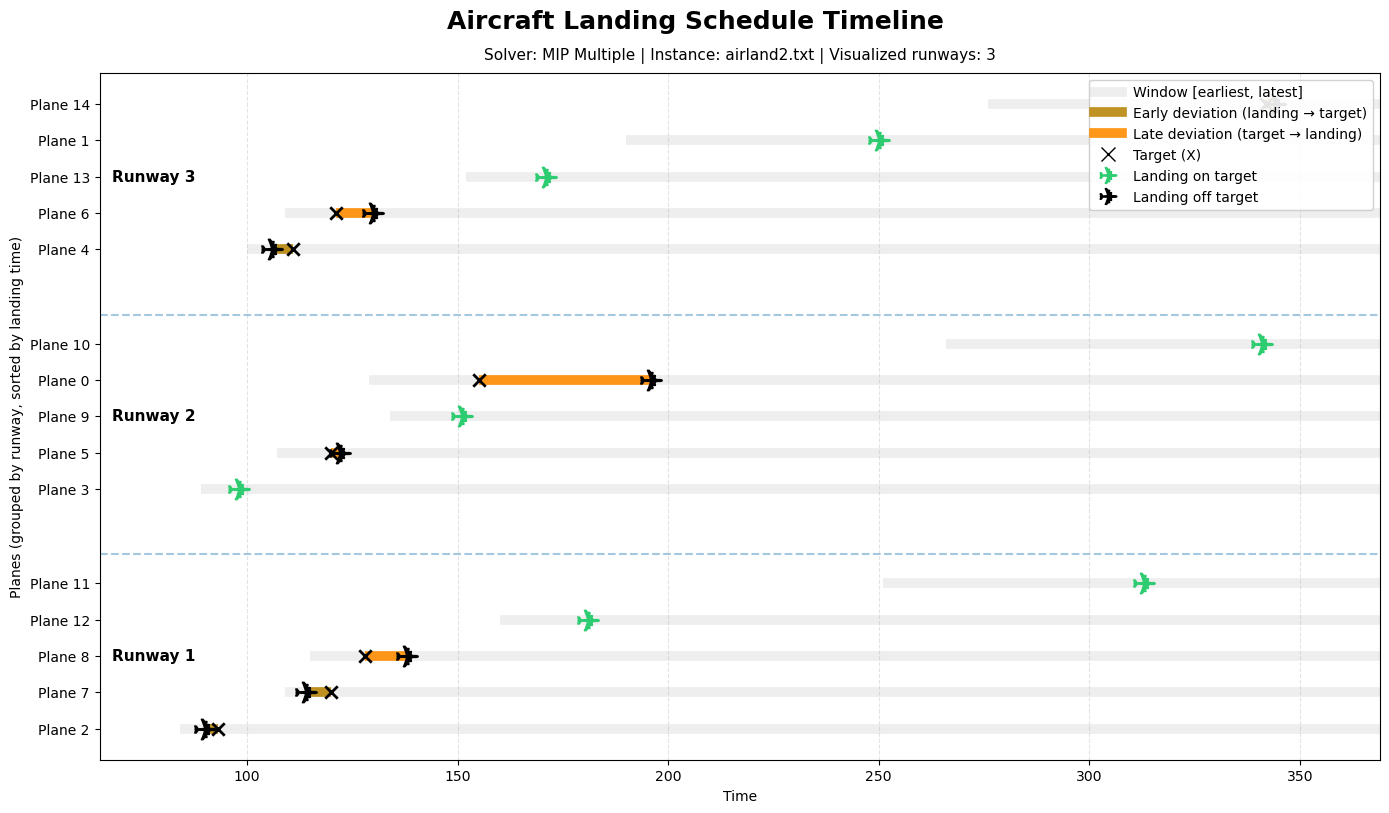

In [19]:
import json
import os
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt


# -----------------------------
# TXT parsing (Airland / ALP)
# -----------------------------

@dataclass
class PlaneWindow:
    idx: int
    appearance: float
    earliest: float
    target: float
    latest: float
    g: float
    h: float


@dataclass
class AirlandInstance:
    n: int
    header2: int
    planes: List[PlaneWindow]
    sep: List[List[float]]


def read_airland_txt(txt_path: str) -> AirlandInstance:
    with open(txt_path, "r", encoding="utf-8") as f:
        tokens = f.read().split()

    pos = 0
    n = int(tokens[pos]); pos += 1
    header2 = int(tokens[pos]); pos += 1

    planes: List[PlaneWindow] = []
    sep = [[0.0 for _ in range(n)] for _ in range(n)]

    for i in range(n):
        appearance = float(tokens[pos]); pos += 1
        earliest = float(tokens[pos]); pos += 1
        target = float(tokens[pos]); pos += 1
        latest = float(tokens[pos]); pos += 1
        g = float(tokens[pos]); pos += 1
        h = float(tokens[pos]); pos += 1

        planes.append(PlaneWindow(i, appearance, earliest, target, latest, g, h))

        for j in range(n):
            sep[i][j] = float(tokens[pos]); pos += 1

    return AirlandInstance(n=n, header2=header2, planes=planes, sep=sep)


# -----------------------------
# JSON parsing (multi-solver)
# -----------------------------

def load_multi_solver_json(json_path: str) -> Dict[str, List[dict]]:
    """
    Expected:
      { "MIP Single": [sol1, sol2, ...],
        "CP": [...],
        "Hybrid": [...] }
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if not isinstance(data, dict):
        raise ValueError("Invalid JSON: expected a dict {solver_name: [solutions...]}")

    out: Dict[str, List[dict]] = {}
    for solver, sols in data.items():
        if not isinstance(sols, list):
            raise ValueError(f"Invalid JSON: solver '{solver}' must map to a list of solutions.")
        out[str(solver)] = sols
    return out


def find_solution(solutions_by_solver: Dict[str, List[dict]], solver: str, file_name: str) -> dict:
    if solver not in solutions_by_solver:
        raise ValueError(f"Solver '{solver}' not found. Available: {list(solutions_by_solver.keys())}")

    for sol in solutions_by_solver[solver]:
        if str(sol.get("file", "")).strip() == file_name:
            return sol

    available_files = [s.get("file") for s in solutions_by_solver[solver]]
    raise ValueError(
        f"Solution for file='{file_name}' not found under solver '{solver}'.\n"
        f"Available files for this solver: {available_files}"
    )


def landing_times_and_runways(solution: dict) -> Tuple[Dict[int, float], Dict[int, int]]:
    lt: Dict[int, float] = {}
    rw: Dict[int, int] = {}
    for row in solution.get("landing_times", []):
        p = int(row["plane"])
        lt[p] = float(row["landing_time"])
        if "runway" in row and row["runway"] is not None:
            rw[p] = int(row["runway"])
    return lt, rw


# -----------------------------
# Runway assignment (fallback)
# -----------------------------

def assign_runways_balanced(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    num_runways: int,
) -> Tuple[Dict[int, int], List[Tuple[int, int]]]:
    """
    Balanced feasible assignment by increasing landing time (fallback only).
    """
    planes_sorted = sorted(landing_times.keys(), key=lambda p: landing_times[p])

    runway_last: List[Optional[int]] = [None] * num_runways
    runway_load: List[int] = [0] * num_runways
    runway_of_plane: Dict[int, int] = {}
    violations: List[Tuple[int, int]] = []

    for p in planes_sorted:
        tp = landing_times[p]

        feasible_runways: List[int] = []
        for r in range(num_runways):
            last = runway_last[r]
            if last is None:
                feasible_runways.append(r)
            else:
                if tp - landing_times[last] >= instance.sep[last][p]:
                    feasible_runways.append(r)

        if feasible_runways:
            def tie_key(r: int):
                last = runway_last[r]
                last_t = landing_times[last] if last is not None else float("-inf")
                return (runway_load[r], last_t)

            chosen = min(feasible_runways, key=tie_key)
            runway_of_plane[p] = chosen
            runway_last[chosen] = p
            runway_load[chosen] += 1
            continue

        best_r = 0
        best_violation = float("inf")
        best_prev = None

        for r in range(num_runways):
            last = runway_last[r]
            if last is None:
                best_r = r
                best_violation = 0.0
                best_prev = None
                break

            required = instance.sep[last][p]
            actual_gap = tp - landing_times[last]
            violation = max(0.0, required - actual_gap)

            if violation < best_violation:
                best_violation = violation
                best_r = r
                best_prev = last

        runway_of_plane[p] = best_r
        if best_prev is not None and best_violation > 0:
            violations.append((best_prev, p))

        runway_last[best_r] = p
        runway_load[best_r] += 1

    return runway_of_plane, violations


def build_runway_mapping(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    num_runways: int,
    json_runways: Dict[int, int],
) -> Tuple[Dict[int, int], List[Tuple[int, int]]]:
    """
    Use runway assignments from JSON if available for all planes,
    otherwise fallback to balanced assignment.
    """
    if len(json_runways) == len(landing_times) and len(landing_times) > 0:
        runway_of_plane = {p: int(json_runways[p]) for p in landing_times.keys()}
        return runway_of_plane, []
    return assign_runways_balanced(instance, landing_times, num_runways)


# -----------------------------
# Plotting helpers
# -----------------------------

def landing_color(t: float, target: float, eps: float = 1e-9) -> str:
    ON_TARGET_GREEN = "#2ECC71"  # slightly lighter green
    if abs(t - target) <= eps:
        return ON_TARGET_GREEN
    return "black"


def compute_zoom_limits(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    pad: float = 25.0,
) -> Tuple[float, float]:
    xs: List[float] = []
    for i in range(instance.n):
        pw = instance.planes[i]
        xs.append(pw.target)
        if i in landing_times:
            xs.append(landing_times[i])

    xmin = min(xs) - pad
    xmax = max(xs) + pad

    if xmax - xmin < 40:
        mid = 0.5 * (xmin + xmax)
        xmin = mid - 30
        xmax = mid + 30

    return xmin, xmax


def plot_landing_gantt_multi_runway(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    runway_of_plane: Dict[int, int],
    num_runways: int,
    fancy_title: str,
    subtitle: str,
    zoom: bool = True,
):
    # Colors (forced)
    WINDOW_COLOR = "#D0D0D0"      # window = light gray (avoid baby-blue)
    EARLY_SEG = "#B8860B"         # dark yellow (early)
    LATE_SEG = "#FF8C00"          # dark orange (late)
    TARGET_COLOR = "black"
    ON_TARGET_GREEN = "#2ECC71"

    # Group planes by runway, then sort by landing time (ascending)
    runway_planes: List[List[int]] = [[] for _ in range(num_runways)]
    for p, t in landing_times.items():
        r = runway_of_plane.get(p, 0)
        if 0 <= r < num_runways:
            runway_planes[r].append(p)

    for r in range(num_runways):
        runway_planes[r].sort(key=lambda p: landing_times[p])

    # Build y positions with runway blocks + gaps (only for non-empty runways)
    gap = 1.6
    y_positions: Dict[int, float] = {}
    runway_bounds: List[Tuple[int, float, float]] = []  # (runway_index, ymin, ymax)

    y_cursor = 0.0
    for r in range(num_runways):
        planes = runway_planes[r]
        if not planes:
            continue

        ymin = y_cursor
        for p in planes:
            y_positions[p] = y_cursor
            y_cursor += 1.0
        ymax = y_cursor - 1.0
        runway_bounds.append((r, ymin, ymax))
        y_cursor += gap

    fig_h = max(6, 0.55 * max(10, len(y_positions)))
    fig, ax = plt.subplots(figsize=(14, fig_h))

    # Plot each plane
    for p, y in y_positions.items():
        pw = instance.planes[p]
        t = landing_times[p]

        # Window [earliest, latest] (FORCE gray)
        ax.hlines(
            y=y,
            xmin=pw.earliest,
            xmax=pw.latest,
            linewidth=7,
            alpha=0.35,
            zorder=1,
            color=WINDOW_COLOR,
        )

        # If landing != target: deviation segment + target X
        if abs(t - pw.target) > 1e-9:
            seg_color = EARLY_SEG if t < pw.target else LATE_SEG

            # Deviation segment (FORCE correct color)
            ax.hlines(
                y=y,
                xmin=min(t, pw.target),
                xmax=max(t, pw.target),
                linewidth=7,
                alpha=0.90,
                zorder=2,
                color=seg_color,
            )

            # Target X (FORCE black)
            ax.scatter(
                [pw.target], [y],
                marker="x",
                s=80,
                linewidths=2,
                zorder=4,
                color=TARGET_COLOR,
            )

        # Landing airplane (on top)
        ax.scatter(
            [t], [y],
            marker=r"$✈$",
            s=240,
            c=landing_color(t, pw.target),
            zorder=5,
        )

    # Runway separators + labels
    for idx, (r, ymin, ymax) in enumerate(runway_bounds):
        y_label = 0.5 * (ymin + ymax)
        ax.text(
            0.01, y_label,
            f"Runway {r+1}",
            transform=ax.get_yaxis_transform(),
            va="center",
            fontsize=11,
            fontweight="bold",
        )

        if idx < len(runway_bounds) - 1:
            sep_y = ymax + (gap / 2.0)
            ax.axhline(sep_y, linestyle="--", alpha=0.4, zorder=0)

    # Y ticks in order
    planes_in_order = sorted(y_positions.items(), key=lambda kv: kv[1])
    ax.set_yticks([y for _, y in planes_in_order])
    ax.set_yticklabels([f"Plane {p}" for p, _ in planes_in_order])

    ax.set_xlabel("Time")
    ax.set_ylabel("Planes (grouped by runway, sorted by landing time)")

    fig.suptitle(fancy_title, fontsize=18, fontweight="bold")
    ax.set_title(subtitle, fontsize=11, pad=10)

    ax.grid(True, axis="x", linestyle="--", alpha=0.35)

    # Legend (must match plot exactly)
    legend_handles = [
        Line2D([0], [0], color=WINDOW_COLOR, linewidth=7, alpha=0.35, label="Window [earliest, latest]"),
        Line2D([0], [0], color=EARLY_SEG, linewidth=7, alpha=0.90, label="Early deviation (landing → target)"),
        Line2D([0], [0], color=LATE_SEG,  linewidth=7, alpha=0.90, label="Late deviation (target → landing)"),
        Line2D([0], [0], marker="x", linestyle="None", markersize=10, color="black", label="Target (X)"),
        Line2D([0], [0], marker=r"$✈$", linestyle="None", markersize=12, color=ON_TARGET_GREEN, label="Landing on target"),
        Line2D([0], [0], marker=r"$✈$", linestyle="None", markersize=12, color="black", label="Landing off target"),
    ]
    ax.legend(handles=legend_handles, loc="upper right", framealpha=0.9)

    # Zoom x-axis
    if zoom and len(landing_times) > 0:
        xmin, xmax = compute_zoom_limits(instance, landing_times, pad=25.0)
        ax.set_xlim(xmin, xmax)

    plt.tight_layout()
    plt.show()


# -----------------------------
# Main
# -----------------------------

def main(
    txt_path: str,
    solutions_json_path: str,
    solver: str,
    runways_to_visualize: Optional[int] = None,
    file_name_in_json: Optional[str] = None,
    zoom: bool = True,
):
    instance = read_airland_txt(txt_path)
    solutions_by_solver = load_multi_solver_json(solutions_json_path)

    file_name = file_name_in_json or os.path.basename(txt_path)
    sol = find_solution(solutions_by_solver, solver, file_name)

    lt, json_runways = landing_times_and_runways(sol)

    # Determine number of runways: JSON value (if present) OR 1, then allow override by argument
    json_runways_count = sol.get("num_runways", 1)
    try:
        json_runways_count = int(json_runways_count)
    except Exception:
        json_runways_count = 1

    num_runways = int(runways_to_visualize) if runways_to_visualize is not None else json_runways_count
    num_runways = max(1, num_runways)

    runway_of_plane, violations = build_runway_mapping(
        instance=instance,
        landing_times=lt,
        num_runways=num_runways,
        json_runways=json_runways,
    )

    fancy_title = "Aircraft Landing Schedule Timeline"
    subtitle = f"Solver: {solver} | Instance: {file_name} | Visualized runways: {num_runways}"
    if violations:
        subtitle += f" | (Warning: {len(violations)} separation violation(s) in fallback runway assignment)"

    plot_landing_gantt_multi_runway(
        instance=instance,
        landing_times=lt,
        runway_of_plane=runway_of_plane,
        num_runways=num_runways,
        fancy_title=fancy_title,
        subtitle=subtitle,
        zoom=zoom,
    )


if __name__ == "__main__":
    main(
        txt_path="data/airland2.txt",
        solutions_json_path="results/solutions.json",
        solver="MIP Multiple",
        runways_to_visualize=3,
        file_name_in_json="airland2.txt",
        zoom=True
    )


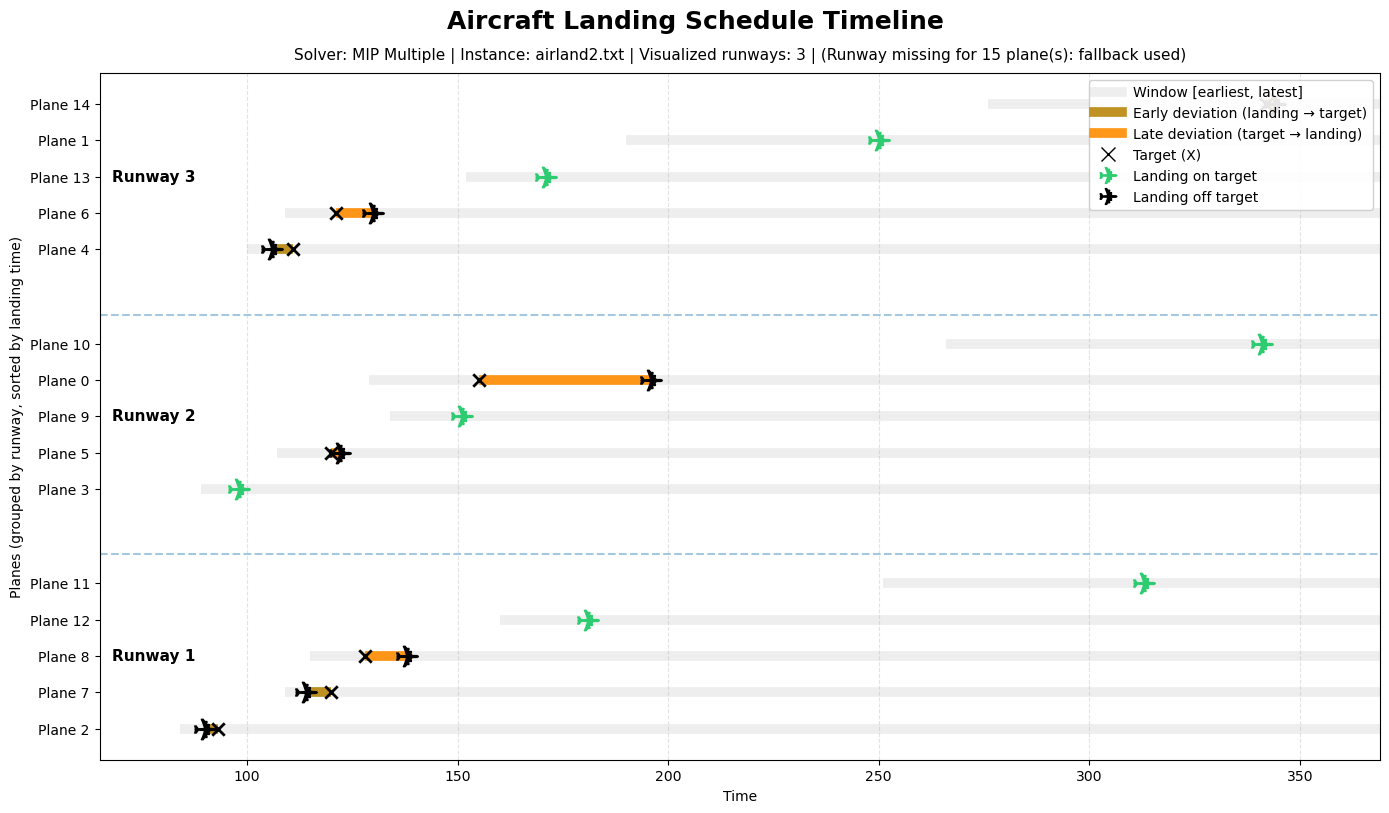

In [21]:
import json
import os
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt


# -----------------------------
# TXT parsing (Airland / ALP)
# -----------------------------

@dataclass
class PlaneWindow:
    idx: int
    appearance: float
    earliest: float
    target: float
    latest: float
    g: float
    h: float


@dataclass
class AirlandInstance:
    n: int
    header2: int
    planes: List[PlaneWindow]
    sep: List[List[float]]


def read_airland_txt(txt_path: str) -> AirlandInstance:
    with open(txt_path, "r", encoding="utf-8") as f:
        tokens = f.read().split()

    pos = 0
    n = int(tokens[pos]); pos += 1
    header2 = int(tokens[pos]); pos += 1

    planes: List[PlaneWindow] = []
    sep = [[0.0 for _ in range(n)] for _ in range(n)]

    for i in range(n):
        appearance = float(tokens[pos]); pos += 1
        earliest = float(tokens[pos]); pos += 1
        target = float(tokens[pos]); pos += 1
        latest = float(tokens[pos]); pos += 1
        g = float(tokens[pos]); pos += 1
        h = float(tokens[pos]); pos += 1

        planes.append(PlaneWindow(i, appearance, earliest, target, latest, g, h))

        for j in range(n):
            sep[i][j] = float(tokens[pos]); pos += 1

    return AirlandInstance(n=n, header2=header2, planes=planes, sep=sep)


# -----------------------------
# JSON parsing (multi-solver)
# -----------------------------

def load_multi_solver_json(json_path: str) -> Dict[str, List[dict]]:
    """
    Expected:
      { "MIP Single": [sol1, sol2, ...],
        "CP": [...],
        "Hybrid": [...] }
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if not isinstance(data, dict):
        raise ValueError("Invalid JSON: expected a dict {solver_name: [solutions...]}")

    out: Dict[str, List[dict]] = {}
    for solver, sols in data.items():
        if not isinstance(sols, list):
            raise ValueError(f"Invalid JSON: solver '{solver}' must map to a list of solutions.")
        out[str(solver)] = sols
    return out


def find_solution(solutions_by_solver: Dict[str, List[dict]], solver: str, file_name: str) -> dict:
    if solver not in solutions_by_solver:
        raise ValueError(f"Solver '{solver}' not found. Available: {list(solutions_by_solver.keys())}")

    for sol in solutions_by_solver[solver]:
        if str(sol.get("file", "")).strip() == file_name:
            return sol

    available_files = [s.get("file") for s in solutions_by_solver[solver]]
    raise ValueError(
        f"Solution for file='{file_name}' not found under solver '{solver}'.\n"
        f"Available files for this solver: {available_files}"
    )


def landing_times_and_partial_runways(solution: dict) -> Tuple[Dict[int, float], Dict[int, int], List[int]]:
    """
    Reads landing_time for all planes and runway when present.
    Returns:
      landing_times: {plane: time}
      runways_json:  {plane: runway} for planes where runway exists
      missing:       list of plane ids missing runway
    """
    lt: Dict[int, float] = {}
    rw: Dict[int, int] = {}
    missing: List[int] = []

    for row in solution.get("landing_times", []):
        p = int(row["plane"])
        lt[p] = float(row["landing_time"])

        if "runway" in row and row["runway"] is not None:
            rw[p] = int(row["runway"])
        else:
            missing.append(p)

    return lt, rw, missing


# -----------------------------
# Runway assignment fallback
# -----------------------------

def assign_runways_balanced(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    num_runways: int,
) -> Tuple[Dict[int, int], List[Tuple[int, int]]]:
    """
    Balanced feasible assignment by increasing landing time (fallback).
    """
    planes_sorted = sorted(landing_times.keys(), key=lambda p: landing_times[p])

    runway_last: List[Optional[int]] = [None] * num_runways
    runway_load: List[int] = [0] * num_runways
    runway_of_plane: Dict[int, int] = {}
    violations: List[Tuple[int, int]] = []

    for p in planes_sorted:
        tp = landing_times[p]

        feasible_runways: List[int] = []
        for r in range(num_runways):
            last = runway_last[r]
            if last is None:
                feasible_runways.append(r)
            else:
                if tp - landing_times[last] >= instance.sep[last][p]:
                    feasible_runways.append(r)

        if feasible_runways:
            def tie_key(r: int):
                last = runway_last[r]
                last_t = landing_times[last] if last is not None else float("-inf")
                return (runway_load[r], last_t)

            chosen = min(feasible_runways, key=tie_key)
            runway_of_plane[p] = chosen
            runway_last[chosen] = p
            runway_load[chosen] += 1
            continue

        best_r = 0
        best_violation = float("inf")
        best_prev = None

        for r in range(num_runways):
            last = runway_last[r]
            if last is None:
                best_r = r
                best_violation = 0.0
                best_prev = None
                break

            required = instance.sep[last][p]
            actual_gap = tp - landing_times[last]
            violation = max(0.0, required - actual_gap)

            if violation < best_violation:
                best_violation = violation
                best_r = r
                best_prev = last

        runway_of_plane[p] = best_r
        if best_prev is not None and best_violation > 0:
            violations.append((best_prev, p))

        runway_last[best_r] = p
        runway_load[best_r] += 1

    return runway_of_plane, violations


def build_runway_mapping_with_fallback(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    num_runways: int,
    runways_json: Dict[int, int],
) -> Tuple[Dict[int, int], List[Tuple[int, int]], List[int]]:
    """
    Use JSON runway where available. If some planes are missing runway,
    assign runways for the missing ones using fallback.
    """
    missing = [p for p in landing_times.keys() if p not in runways_json]

    violations: List[Tuple[int, int]] = []

    # If nothing missing, just return JSON mapping
    if not missing:
        # sanity check: runway values must be in range
        for p, r in runways_json.items():
            if not (0 <= int(r) < num_runways):
                raise ValueError(
                    f"Plane {p} has runway={r}, but visualized runways are 0..{num_runways-1}."
                )
        return dict(runways_json), violations, missing

    # Fallback assignment ONLY for missing planes
    lt_missing = {p: landing_times[p] for p in missing}
    fallback_map, fallback_violations = assign_runways_balanced(instance, lt_missing, num_runways)

    out = dict(runways_json)
    out.update(fallback_map)
    violations.extend(fallback_violations)

    return out, violations, missing


# -----------------------------
# Plotting helpers
# -----------------------------

def landing_color(t: float, target: float, eps: float = 1e-9) -> str:
    ON_TARGET_GREEN = "#2ECC71"  # slightly lighter green
    if abs(t - target) <= eps:
        return ON_TARGET_GREEN
    return "black"


def compute_zoom_limits(instance: AirlandInstance, landing_times: Dict[int, float], pad: float = 25.0) -> Tuple[float, float]:
    xs: List[float] = []
    for i in range(instance.n):
        pw = instance.planes[i]
        xs.append(pw.target)
        if i in landing_times:
            xs.append(landing_times[i])

    xmin = min(xs) - pad
    xmax = max(xs) + pad

    if xmax - xmin < 40:
        mid = 0.5 * (xmin + xmax)
        xmin = mid - 30
        xmax = mid + 30

    return xmin, xmax


def plot_landing_gantt_multi_runway(
    instance: AirlandInstance,
    landing_times: Dict[int, float],
    runway_of_plane: Dict[int, int],
    num_runways: int,
    fancy_title: str,
    subtitle: str,
    zoom: bool = True,
):
    # Forced colors (match legend exactly)
    WINDOW_COLOR = "#D0D0D0"      # window = light gray
    EARLY_SEG = "#B8860B"         # dark yellow (early)
    LATE_SEG  = "#FF8C00"         # dark orange (late)
    TARGET_COLOR = "black"
    ON_TARGET_GREEN = "#2ECC71"

    # Group planes by runway using runway_of_plane (authoritative after fallback)
    runway_planes: List[List[int]] = [[] for _ in range(num_runways)]
    for p, t in landing_times.items():
        r = int(runway_of_plane.get(p, 0))
        if not (0 <= r < num_runways):
            raise ValueError(
                f"Plane {p} has runway={r}, but visualized runways are 0..{num_runways-1}."
            )
        runway_planes[r].append(p)

    # Sort each runway by landing time
    for r in range(num_runways):
        runway_planes[r].sort(key=lambda p: landing_times[p])

    # Build y positions with runway blocks + gaps (keep runway order stable)
    gap = 1.6
    y_positions: Dict[int, float] = {}
    runway_bounds: List[Tuple[int, float, float]] = []  # (runway_index, ymin, ymax)

    y_cursor = 0.0
    for r in range(num_runways):
        planes = runway_planes[r]
        ymin = y_cursor

        if planes:
            for p in planes:
                y_positions[p] = y_cursor
                y_cursor += 1.0
            ymax = y_cursor - 1.0
        else:
            # reserve a small band even if empty so dashed separators align
            ymax = y_cursor
            y_cursor += 1.0

        runway_bounds.append((r, ymin, ymax))
        y_cursor += gap

    fig_h = max(6, 0.55 * max(10, len(landing_times)))
    fig, ax = plt.subplots(figsize=(14, fig_h))

    # Plot each plane (in any order; y_positions fixes placement)
    for p, t in landing_times.items():
        y = y_positions[p]
        pw = instance.planes[p]

        # Window [earliest, latest] - FORCE gray (avoid baby blue)
        ax.hlines(
            y=y,
            xmin=pw.earliest,
            xmax=pw.latest,
            linewidth=7,
            alpha=0.35,
            zorder=1,
            color=WINDOW_COLOR,
        )

        # If landing != target: deviation segment + target X
        if abs(t - pw.target) > 1e-9:
            seg_color = EARLY_SEG if t < pw.target else LATE_SEG

            # deviation segment - FORCE seg color
            ax.hlines(
                y=y,
                xmin=min(t, pw.target),
                xmax=max(t, pw.target),
                linewidth=7,
                alpha=0.90,
                zorder=2,
                color=seg_color,
            )

            # target X - FORCE black
            ax.scatter(
                [pw.target], [y],
                marker="x",
                s=80,
                linewidths=2,
                zorder=4,
                color=TARGET_COLOR,
            )

        # landing airplane - ALWAYS ON TOP
        ax.scatter(
            [t], [y],
            marker=r"$✈$",
            s=240,
            c=landing_color(t, pw.target),
            zorder=5,
        )

    # Runway separators + labels
    for r, ymin, ymax in runway_bounds:
        y_label = 0.5 * (ymin + ymax)
        ax.text(
            0.01, y_label,
            f"Runway {r+1}",
            transform=ax.get_yaxis_transform(),
            va="center",
            fontsize=11,
            fontweight="bold",
        )

        if r < num_runways - 1:
            sep_y = ymax + (gap / 2.0)
            ax.axhline(sep_y, linestyle="--", alpha=0.4, zorder=0)

    # Y ticks: show planes in visual order
    planes_in_order = sorted(y_positions.items(), key=lambda kv: kv[1])
    ax.set_yticks([y for _, y in planes_in_order])
    ax.set_yticklabels([f"Plane {p}" for p, _ in planes_in_order])

    ax.set_xlabel("Time")
    ax.set_ylabel("Planes (grouped by runway, sorted by landing time)")

    fig.suptitle(fancy_title, fontsize=18, fontweight="bold")
    ax.set_title(subtitle, fontsize=11, pad=10)

    ax.grid(True, axis="x", linestyle="--", alpha=0.35)

    # Legend (matches plot)
    legend_handles = [
        Line2D([0], [0], color=WINDOW_COLOR, linewidth=7, alpha=0.35, label="Window [earliest, latest]"),
        Line2D([0], [0], color=EARLY_SEG, linewidth=7, alpha=0.90, label="Early deviation (landing → target)"),
        Line2D([0], [0], color=LATE_SEG,  linewidth=7, alpha=0.90, label="Late deviation (target → landing)"),
        Line2D([0], [0], marker="x", linestyle="None", markersize=10, color="black", label="Target (X)"),
        Line2D([0], [0], marker=r"$✈$", linestyle="None", markersize=12, color=ON_TARGET_GREEN, label="Landing on target"),
        Line2D([0], [0], marker=r"$✈$", linestyle="None", markersize=12, color="black", label="Landing off target"),
    ]
    ax.legend(handles=legend_handles, loc="upper right", framealpha=0.9)

    # Zoom x-axis around target/landing region
    if zoom and landing_times:
        xmin, xmax = compute_zoom_limits(instance, landing_times, pad=25.0)
        ax.set_xlim(xmin, xmax)

    plt.tight_layout()
    plt.show()


# -----------------------------
# Main
# -----------------------------

def main(
    txt_path: str,
    solutions_json_path: str,
    solver: str,
    runways_to_visualize: Optional[int] = None,
    file_name_in_json: Optional[str] = None,
    zoom: bool = True,
):
    instance = read_airland_txt(txt_path)
    solutions_by_solver = load_multi_solver_json(solutions_json_path)

    file_name = file_name_in_json or os.path.basename(txt_path)
    sol = find_solution(solutions_by_solver, solver, file_name)

    lt, runways_json, missing = landing_times_and_partial_runways(sol)

    # Determine number of runways to visualize
    json_runways_count = sol.get("num_runways", 1)
    try:
        json_runways_count = int(json_runways_count)
    except Exception:
        json_runways_count = 1

    num_runways = int(runways_to_visualize) if runways_to_visualize is not None else json_runways_count
    num_runways = max(1, num_runways)

    runway_of_plane, violations, missing_after = build_runway_mapping_with_fallback(
        instance=instance,
        landing_times=lt,
        num_runways=num_runways,
        runways_json=runways_json,
    )

    fancy_title = "Aircraft Landing Schedule Timeline"
    subtitle = f"Solver: {solver} | Instance: {file_name} | Visualized runways: {num_runways}"

    # Add warning if JSON missing runway for some planes
    if missing_after:
        subtitle += f" | (Runway missing for {len(missing_after)} plane(s): fallback used)"
    if violations:
        subtitle += f" | (Fallback violations: {len(violations)})"

    plot_landing_gantt_multi_runway(
        instance=instance,
        landing_times=lt,
        runway_of_plane=runway_of_plane,
        num_runways=num_runways,
        fancy_title=fancy_title,
        subtitle=subtitle,
        zoom=zoom,
    )


if __name__ == "__main__":
    main(
        txt_path="data/airland2.txt",
        solutions_json_path="results/solutions.json",
        solver="MIP Multiple",
        runways_to_visualize=3,
        file_name_in_json="airland2.txt",
        zoom=True
    )
